In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
chembl_raw_df = pd.read_csv('Chembl_data_5HT2A.csv', index_col=0)
chembl_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5454 entries, CHEMBL4212943 to CHEMBL134519
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule Name               1198 non-null   object 
 1   Molecule Max Phase          1045 non-null   float64
 2   Molecular Weight            5454 non-null   float64
 3   #RO5 Violations             5423 non-null   float64
 4   AlogP                       5423 non-null   float64
 5   Compound Key                5454 non-null   object 
 6   Smiles                      5454 non-null   object 
 7   Standard Type               5454 non-null   object 
 8   Standard Relation           4467 non-null   object 
 9   Standard Value              4490 non-null   float64
 10  Standard Units              4504 non-null   object 
 11  pChEMBL Value               3949 non-null   float64
 12  Data Validity Comment       20 non-null     object 
 13  Comment           

In [10]:
zinc_raw_df = pd.read_csv('ZINC_data_5HT2A.csv', index_col=0)
zinc_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, ZINC000029038589 to ZINC000058650261
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   smiles               2877 non-null   object 
 1   ortholog_name        2877 non-null   object 
 2   gene_name            2877 non-null   object 
 3   affinity             2877 non-null   float64
 4   chembldocid          2877 non-null   int64  
 5   title                97 non-null     object 
 6   reference.pubmed_id  2701 non-null   float64
 7   reference.doi        116 non-null    object 
 8   reference.chembl_id  2877 non-null   object 
 9   reference.journal    2780 non-null   object 
 10  reference.year       2780 non-null   float64
 11  pKi_numeric          2877 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 292.2+ KB


In [39]:
mask = chembl_raw_df['relation_clean'] == '='
chembl_raw_df.loc[mask, 'pKi_recalculated'] = -np.log10(chembl_raw_df.loc[mask, 'Standard Value'] / 1e9)
chembl_raw_df['pKi_delta'] = chembl_raw_df['pKi_recalculated'] - chembl_raw_df['pKi_numeric']
#zinc_raw_df['label'] = 'zinc'
#chembl_raw_df['label'] = 'chembl'
zinc_subset = zinc_raw_df[['pKi_numeric', 'smiles']].rename(columns={'smiles': 'Smiles', 'pKi_numeric': 'pKi'})
chembl_subset = chembl_raw_df.query("relation_clean == '='")[['pKi_recalculated', 'Smiles']].rename(columns={'pKi_recalculated': 'pKi'})

merged_data = pd.concat([zinc_subset, chembl_subset], ignore_index=True)
merged_data = merged_data.reset_index(drop=False)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6832 entries, 0 to 6831
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   6832 non-null   int64  
 1   pKi     6832 non-null   float64
 2   Smiles  6832 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 160.3+ KB


In [90]:
def deduplicate_smiles(smile):
    if len(smile) == 1:
        return smile
    delta = smile['pKi'].max() - smile['pKi'].min()
    if delta > 0.1:
        return pd.DataFrame(columns=smile.columns)
    else:
        idx = smile['index'].idxmin()
        return smile.loc[[idx]]


deduplicated_df = merged_data.groupby('Smiles', group_keys=False).apply(deduplicate_smiles).drop(columns='index')
deduplicated_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4846 entries, 6291 to 1361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pKi     4846 non-null   float64
 1   Smiles  4846 non-null   object 
dtypes: float64(1), object(1)
memory usage: 113.6+ KB


C:\Users\User\AppData\Local\Temp\ipykernel_4588\2152655396.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  deduplicated_df = merged_data.groupby('Smiles', group_keys=False).apply(deduplicate_smiles).drop(columns='index')
C:\Users\User\AppData\Local\Temp\ipykernel_4588\2152655396.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deduplicated_df = merged_data.groupby('Smiles', group_keys=False).apply(deduplicate_smiles).drop(columns='index')


In [115]:
mordred_df = pd.read_csv('Mordred_descriptors_database.csv')
smiles_df = mordred_df['smiles']
mordred_df = mordred_df.apply(pd.to_numeric, errors='coerce')

C:\Users\User\AppData\Local\Temp\ipykernel_4588\2255507516.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,54,55,56,57,58,59,60,61,62,136,137,138,139,140,141,142,145,146,147,148,149,150,151,153,154,155,156,157,158,159,160,163,164,165,166,167,168,169,172,173,174,175,176,177,178,181,182,183,184,185,186,187,190,191,192,193,194,195,196,199,200,201,202,203,204,205,208,209,210,211,212,213,214,217,218,219,220,221,222,223,226,227,228,229,230,231,232,234,235,236,237,238,239,240,241,242,261,262,263,264,265,266,267,268,269,342,343,344,345,346,347,348,349,352,353,354,355,356,357,358,361,362,363,364,365,366,367,369,370,371,372,373,374,375,376,379,380,381,382,383,384,385,388,389,390,391,392,393,394,397,398,399,400,401,402,403,406,407,408,409,410,411,412,415,416,417,418,419,420,421,424,425,426,427,428,429,430,433,434,435,436,437,438,439,442,443,444,445,446,447,448,450,451,452,453,454,455,456,458,459,460,461,462,463,464,466,467,468,469,470,471,472,474,475,476,477,478,479,480,482,483,484,48

In [116]:
null_proportion = mordred_df.isnull().mean()
mordred_df_cleaned = mordred_df.loc[:, null_proportion <= 0.1]
mordred_df_cleaned['smiles'] = smiles_df.to_frame()
mordred_df_cleaned
mordred_df_cleaned.info()
mordred_df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Columns: 1430 entries, nAcid to smiles
dtypes: bool(2), float64(1115), int64(312), object(1)
memory usage: 76.4+ MB


C:\Users\User\AppData\Local\Temp\ipykernel_4588\3968219691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mordred_df_cleaned['smiles'] = smiles_df.to_frame()


nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A  \
0      0      1  42.064663  2.474394  4.948788  42.064663  1.274687  4.421522   
1      0      1  22.566900  2.539343  4.980643  22.566900  1.327465  3.792159   
2      0      1  33.403027  2.421426  4.721185  33.403027  1.336121  4.164574   
3      0      1  34.277891  2.414987  4.699237  34.277891  1.318380  4.201200   
4      0      1  43.732906  2.375217  4.750433  43.732906  1.325240  4.416221   

      VE1_A     VE2_A  ...     TSRW10          MW       AMW  WPath  WPol  \
0  3.844771  0.116508  ...  69.176088  452.211136  7.293728   3940    53   
1  3.698109  0.217536  ...  66.014285  235.120843  6.915319    452    28   
2  3.676501  0.147060  ...  76.384627  336.158626  7.470192   1815    33   
3  3.663302  0.140896  ...  76.660405  350.143056  7.780957   2065    36   
4  3.886549  0.117774  ...  68.855801  480.148367  8.138108   4316    50   

   Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0    172.0    201.0  10.472222  7.250000   
1     92.0    114.0   4.916667  3.916667   
2    132.0    155.0   6.027778  5.583333   
3    138.0    161.0   6.888889  5.666667   
4    168.0    194.0   9.250000  7.388889   

                                              smiles  
0  CC(=O)c1c(OCCCCN2CCN(c3cccc(F)c3)CC2)ccc2c(C)c...  
1                        COc1c2c(c(CCN)c3c1OCC3)CCO2  
2       COc1ccc2[nH]cc(CCNCc3ccc(-c4cn[nH]c4)o3)c2c1  
3       Oc1ccc(-c2ccc(CNCCc3c[nH]c4cc(F)ccc34)o2)cc1  
4  O=C(NC/C=C/CN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc(-c2...  

[5 rows x 1430 columns]

In [117]:
final_df = pd.merge(mordred_df_cleaned, deduplicated_df, left_on='smiles', right_on='Smiles', how='inner')
final_df = final_df.drop(columns=['smiles', 'Smiles'], axis=1)
final_df

nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A  \
0         0      1  42.064663  2.474394  4.948788  42.064663  1.274687   
1         0      1  33.403027  2.421426  4.721185  33.403027  1.336121   
2         0      1  34.277891  2.414987  4.699237  34.277891  1.318380   
3         0      1  43.732906  2.375217  4.750433  43.732906  1.325240   
4         0      5  30.407067  2.431829  4.863658  30.407067  1.266961   
...     ...    ...        ...       ...       ...        ...       ...   
4841      0      2  46.094646  2.666854  5.256035  46.094646  1.280407   
4842      0      1  34.660101  2.434773  4.806021  34.660101  1.333081   
4843      0      2  46.094646  2.666854  5.256035  46.094646  1.280407   
4844      0      2  30.023481  2.520322  5.040645  30.023481  1.305369   
4845      0      2  30.023481  2.520322  5.040645  30.023481  1.305369   

       LogEE_A     VE1_A     VE2_A  ...     TSRW10          MW       AMW  \
0     4.421522  3.844771  0.116508  ...  69.176088  452.211136  7.293728   
1     4.164574  3.676501  0.147060  ...  76.384627  336.158626  7.470192   
2     4.201200  3.663302  0.140896  ...  76.660405  350.143056  7.780957   
3     4.416221  3.886549  0.117774  ...  68.855801  480.148367  8.138108   
4     4.103188  4.011701  0.167154  ...  58.556000  328.201159  6.837524   
...        ...       ...       ...  ...        ...         ...       ...   
4841  4.528618  4.013938  0.111498  ...  87.904625  493.294057  6.577254   
4842  4.196527  3.925313  0.150974  ...  74.369590  357.171336  7.764594   
4843  4.528618  4.013938  0.111498  ...  87.904625  493.294057  6.577254   
4844  4.065715  4.099187  0.178226  ...  57.718886  318.230728  6.004353   
4845  4.065715  4.099187  0.178226  ...  57.718886  318.230728  6.004353   

      WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2       pKi  
0      3940    53    172.0    201.0  10.472222  7.250000  6.397940  
1      1815    33    132.0    155.0   6.027778  5.583333  7.552842  
2      2065    36    138.0    161.0   6.888889  5.666667  7.017729  
3      4316    50    168.0    194.0   9.250000  7.388889  7.200000  
4      1409    36    124.0    143.0   7.368056  5.361111  5.881735  
...     ...   ...      ...      ...        ...       ...       ...  
4841   4674    63    198.0    240.0  11.645833  7.763889  5.010000  
4842   1862    36    136.0    157.0   6.277778  5.722222  5.010000  
4843   4674    63    198.0    240.0  11.645833  7.763889  5.010000  
4844   1110    40    120.0    144.0   7.118056  5.347222  5.000000  
4845   1110    40    120.0    144.0   7.118056  5.347222  5.000000  

[4846 rows x 1430 columns]

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import tree

# 'pKi' to zmienna docelowa
X = final_df.drop(columns=['pKi'])
y = final_df['pKi']

# train+val oraz test (80% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train+val na osobne train i val (75% / 25% z tych 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# finalne proporcje:
# - train: 60%
# - val: 20%
# - test: 20%

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (2907, 1429), Validation: (969, 1429), Test: (970, 1429)


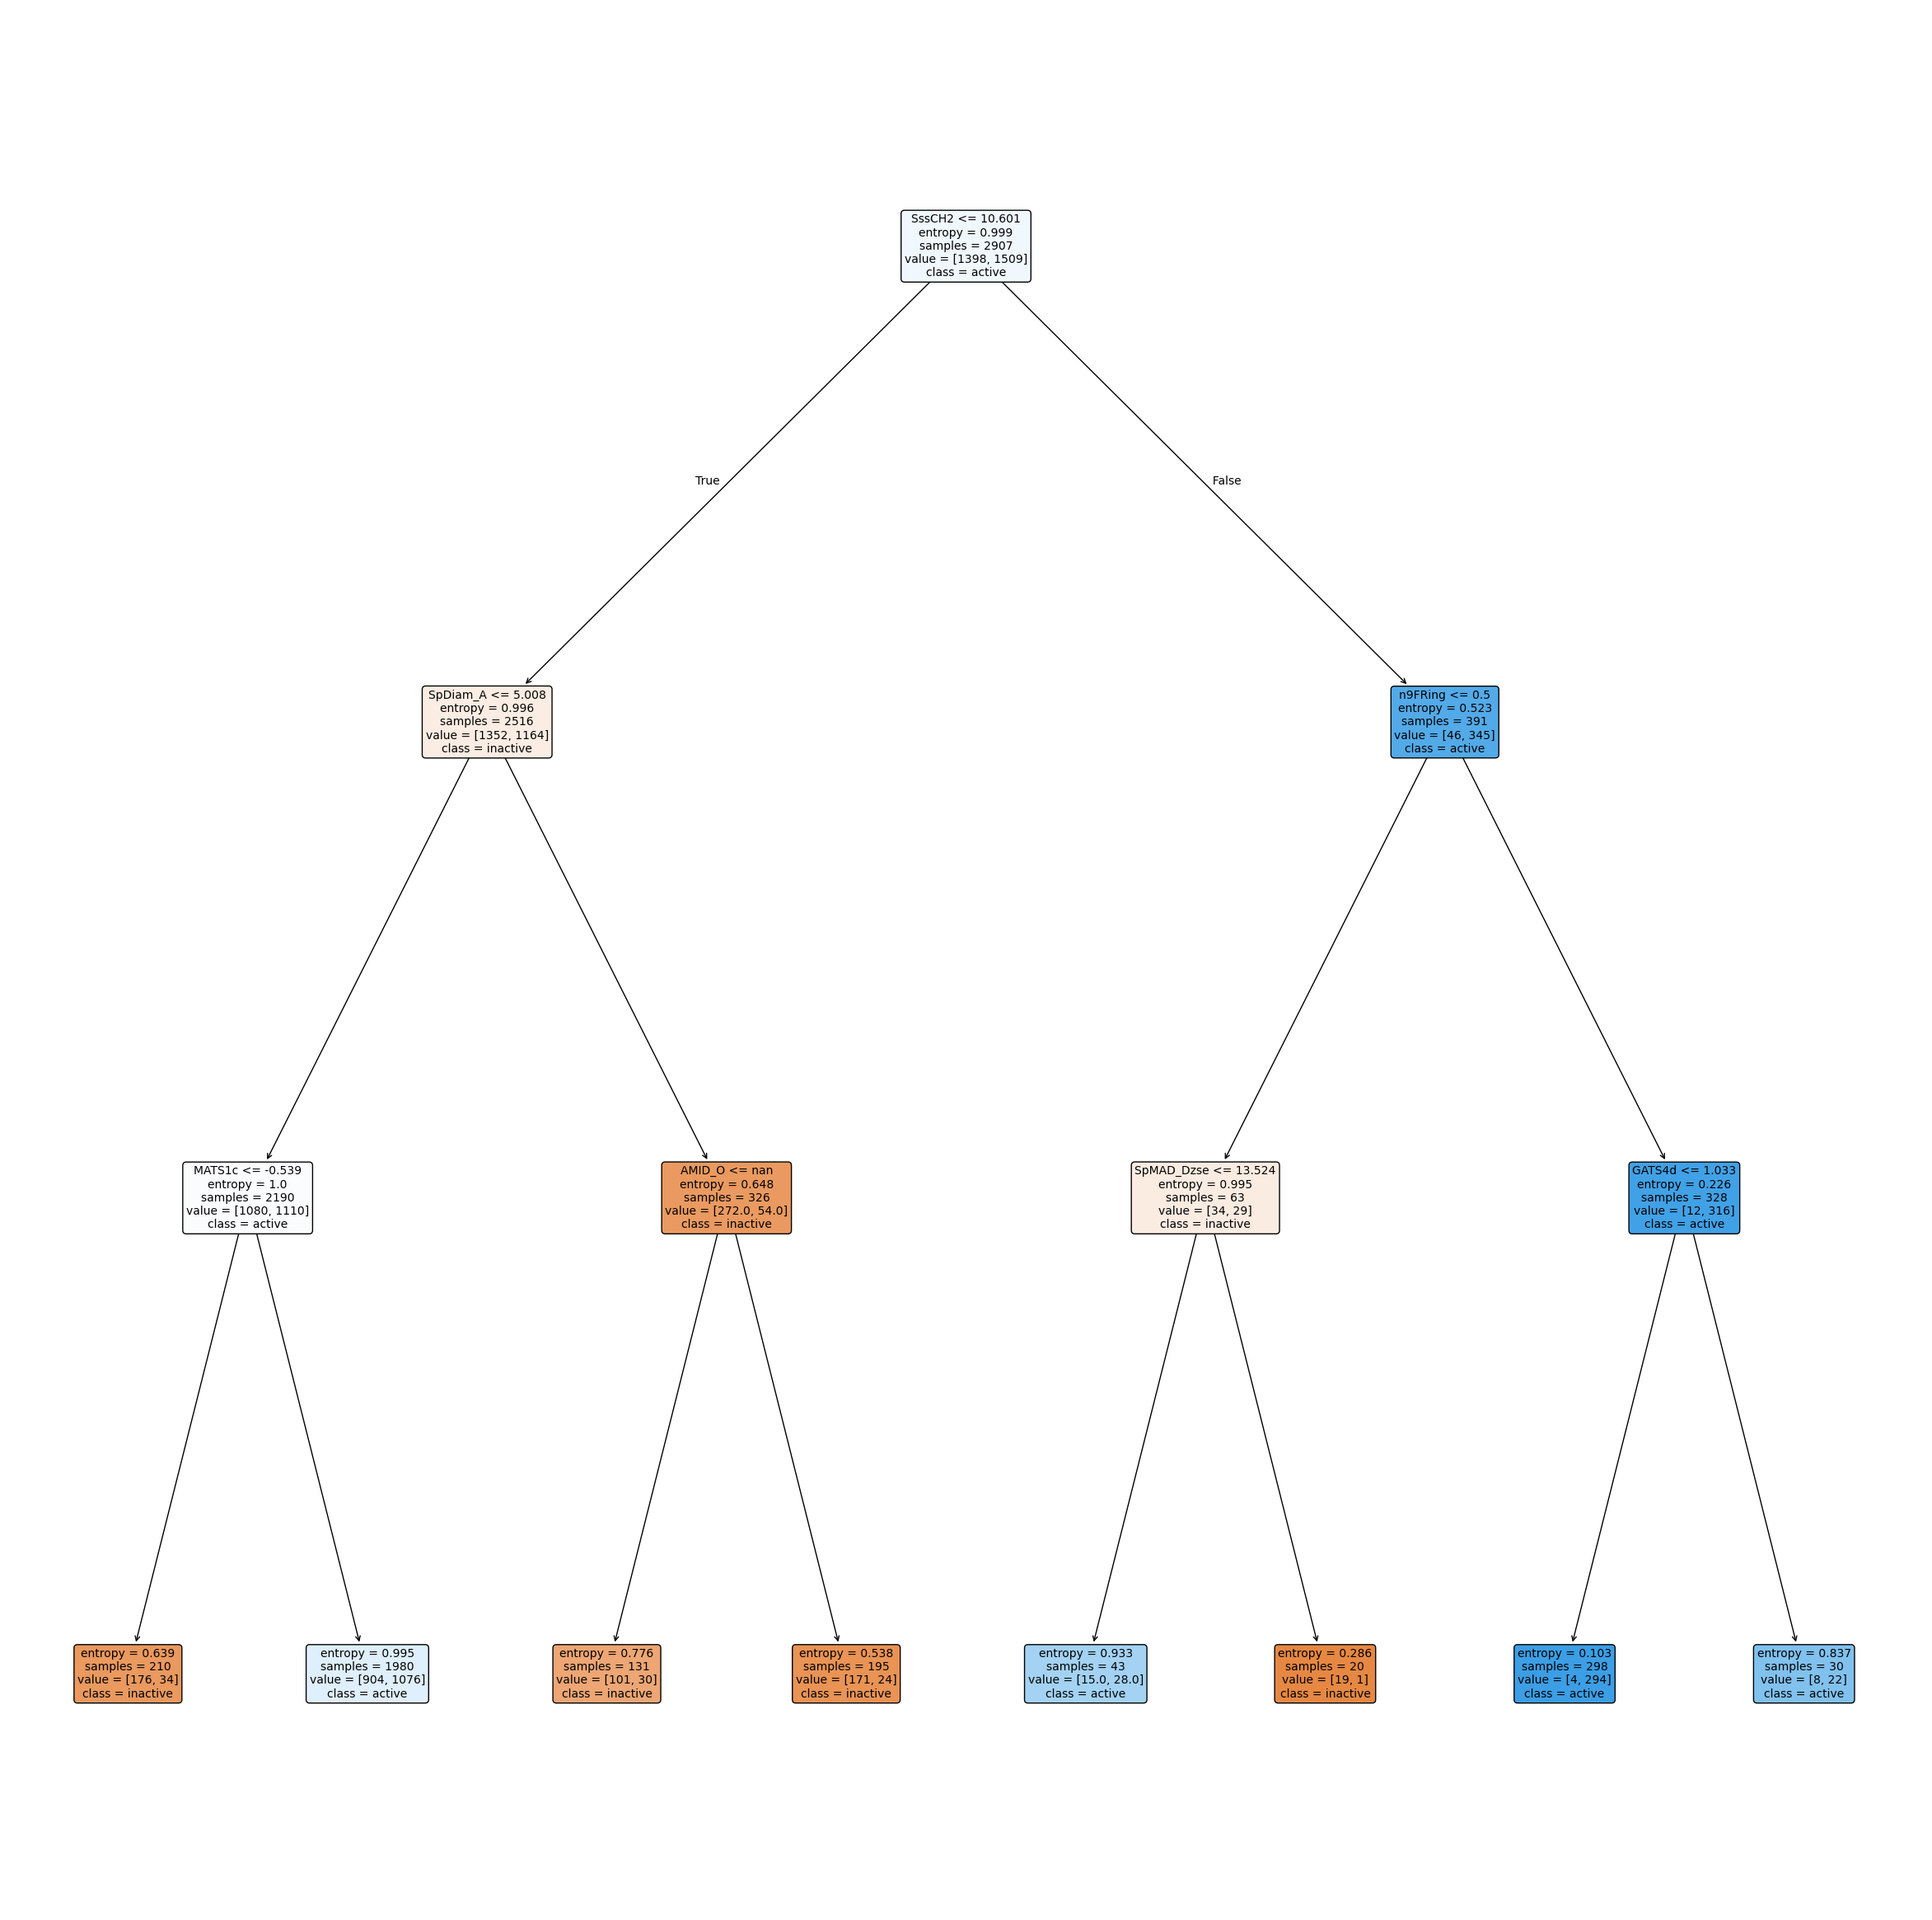

In [119]:
# 1. Stworzenie etykiet: aktywny = 1 (pKi > 7), inaczej 0
y_train_bin = (y_train > 7).astype(int)
y_val_bin = (y_val > 7).astype(int)
y_test_bin = (y_test > 7).astype(int)
feature_names = X_train.columns.tolist()
class_names = ['inactive', 'active']

# wybór modelu drzewa decyzyjnego i uczenie
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

clf.fit(X_train, y_train_bin)

#predykcja
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

#wizualizacja drzewa decyzyjnego
plt.figure(figsize=(30,30))
tree.plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, fontsize=10, rounded=True, max_depth=3)
plt.show()

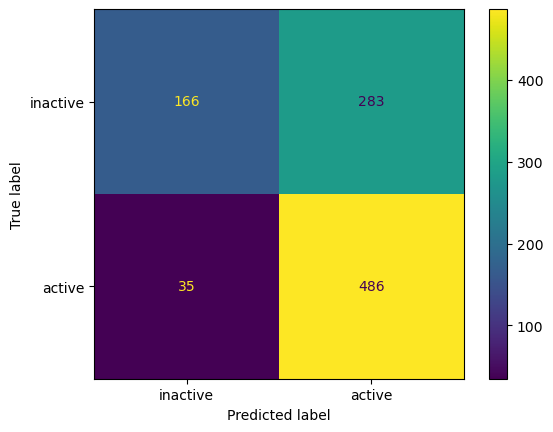

In [120]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test_bin, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

# dokładność
accuracy = accuracy_score(y_val_bin, y_val_pred)
# precyzja
precision = precision_score(y_val_bin, y_val_pred)
# czułość
recall = recall_score(y_val_bin, y_val_pred)
#ROC_AUC
roc_auc = roc_auc_score(y_val_bin, y_val_pred)

print(classification_report(y_val_bin, y_val_pred, target_names=['inactive', 'active']))
print(f"ROC_AUC_score: {roc_auc:.4f}")


              precision    recall  f1-score   support

    inactive       0.82      0.34      0.48       464
      active       0.61      0.93      0.73       505

    accuracy                           0.65       969
   macro avg       0.71      0.64      0.61       969
weighted avg       0.71      0.65      0.61       969

ROC_AUC_score: 0.6367


In [123]:
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator

h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...


H2OStartupError: Cannot find Java. Please install the latest JRE from
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements

ModuleNotFoundError: No module named 'tensorflow'